##Initialization

In [54]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from collections import defaultdict
import random
np.random.seed(211)

In [55]:
import requests
import zipfile
import io

# URL of the dataset.
url = "https://archive.ics.uci.edu/static/public/380/youtube+spam+collection.zip"

# Download the dataset.
response = requests.get(url)

# Unzip the downloaded content.
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall()

# PSY - Gangnam style comments

## Data preprocessing/tokenization

In [100]:
# Number of states (ham, spam) and features.
n_states = 2

# Maximum number of words that will be defined its sown token.
n_features = 400

# Load the dataset.
df = pd.read_csv("Youtube01-Psy.csv", header=None, names=["ID", "Author", "Date", "Message", "Label"])

In [101]:
# Map labels ham/spam to binary values.
df['Label'] = df['Label'].map({'0': 0, '1': 1})

# Train/Val/Test split: 80%/10%/10%
train_data = df.sample(n=int((df.shape[0])*0.8), random_state=10)
rem = df.drop(train_data.index)
val_data = rem.sample(n=int((rem.shape[0])*0.5), random_state=10)
test_data = rem.drop(val_data.index)

# Extract text data and labels.
train_text = train_data['Message'].tolist()
train_labels = train_data['Label'].tolist()
val_text = val_data['Message'].tolist()
val_labels = val_data['Label'].tolist()
test_text = test_data['Message'].tolist()
test_labels = test_data['Label'].tolist()

#train_text = train_text[:500]
#train_labels = train_labels[:500]
#val_text = val_text[:100]
#val_labels = val_labels[:100]
#test_text = test_text[:100]
#test_labels = test_labels[:100]

# Initialize a vocabulary and assign each unique word an integer ID.
word_to_id = defaultdict(lambda: len(word_to_id))

# Special tokens for padding and unknown words
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"
word_to_id[PAD_TOKEN] = 0
word_to_id[UNK_TOKEN] = 1

# Function to tokenize and encode each message.
def tokenize_and_encode(msgs, word_to_id):
    encoded_sequences = []
    for msg in msgs:
        tokens = msg.split()
        encoded_msg = [word_to_id[token] if token in word_to_id else word_to_id[UNK_TOKEN]
                           for token in tokens]
        encoded_sequences.append(encoded_msg)
    return encoded_sequences

In [102]:
# Assign each string in the dataset a token
text_data_shuffle = train_data['Message'].tolist()
random.shuffle(text_data_shuffle)
for message in text_data_shuffle:
  tokens = message.split() # Split the strings in each message to process every word separately.
  for token in tokens:
    if len(word_to_id) >= n_features: # Cap the dictionary length to the defined number of features to prevent overfitting.
      break
    _ = word_to_id[token] # If a word isn't already assigned a token, give it a token.
  if len(word_to_id) >= n_features:
    break

In [103]:
print("Vocabulary:", dict(word_to_id))

Vocabulary: {'<PAD>': 0, '<UNK>': 1, 'The': 2, 'most': 3, 'liked': 4, 'video': 5, 'on': 6, 'YouTube...\ufeff': 7, 'Hey,': 8, 'join': 9, 'me': 10, 'tsū,': 11, 'a': 12, 'publishing': 13, 'platform': 14, 'where': 15, 'I': 16, 'share': 17, 'my': 18, 'content': 19, 'now:': 20, 'http://tsu.co/MarkusMairhofer\ufeff': 21, 'Please': 22, 'help': 23, 'go': 24, 'to': 25, 'college': 26, 'guys!': 27, 'Thanks': 28, 'from': 29, 'the': 30, 'bottom': 31, 'of': 32, 'heart.': 33, 'https://www.indiegogo.com/projects/i-want-to-go-to-college--19/x/9082175\ufeff': 34, 'Why': 35, 'does': 36, 'song': 37, 'like': 38, 'this': 39, 'have': 40, 'more': 41, 'views': 42, 'than': 43, 'Michael': 44, 'Jackson': 45, 'SMH\ufeff': 46, 'Can': 47, 'we': 48, 'reach': 49, '3': 50, 'billion': 51, 'by': 52, 'December': 53, '2014?': 54, '\ufeff': 55, 'imagine': 56, 'if': 57, 'guy': 58, 'put': 59, 'adsense': 60, 'with': 61, 'all': 62, 'these': 63, 'views...': 64, 'u': 65, 'could': 66, 'pay': 67, 'ur': 68, 'morgage\ufeff': 69, 'Chec

In [104]:
# Apply tokenization and encoding to dataset.
token_text = tokenize_and_encode(train_text, word_to_id)

# Pad sequences to the same length for batch processing.
def pad_sequences(sequences, max_length, pad_value=0):
  padded_sequences = []
  for seq in sequences:
    if len(seq) < max_length:
      padded_seq = seq + [pad_value] * (max_length - len(seq))
    else:
      padded_seq = seq[:max_length]
    padded_sequences.append(padded_seq)
  return padded_sequences

# Set a maximum sequence length.
max_length = 70

#Tokenize the training, validation, and test sequences
train_sequences = pad_sequences(token_text, max_length, pad_value=word_to_id[PAD_TOKEN])
val_sequences = pad_sequences(tokenize_and_encode(val_text, word_to_id), max_length, pad_value=word_to_id[PAD_TOKEN])
test_sequences = pad_sequences(tokenize_and_encode(test_text, word_to_id), max_length, pad_value=word_to_id[PAD_TOKEN])

# Convert sequences and labels to PyTorch tensors.
train_sequences = torch.tensor(train_sequences, dtype=torch.long)
#train_labels = torch.tensor(train_labels, dtype=torch.long)
val_sequences = torch.tensor(val_sequences, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_sequences = torch.tensor(test_sequences, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

##Viterbi algorithm and training

In [105]:
# Define transitions.
A = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states,n_states), dim=0)).float()

# Define emissions.
b = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states,n_features), dim=0)).float()

# Define initial state probabilities; state priors.
pi = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states), dim=0)).float()

In [106]:
def viterbi_decoding(observed_sequences, A, b, pi):

  batch_size, seq_len = observed_sequences.shape
  n_states = A.shape[0]

  # Initialize omega and psi.
  omega = torch.zeros(batch_size, seq_len, n_states).float()
  psi = torch.zeros(batch_size, seq_len, n_states).long()

  # Enable CUDA if available.
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  observed_sequences = observed_sequences.to(device)
  A = A.to(device)
  b = b.to(device)
  pi = pi.to(device)
  omega = omega.to(device)
  psi = psi.to(device)

  # Initialize the omega value.
  omega[:, 0, :] = pi + b[:, observed_sequences[:, 0]].T

  # Recursion.
  for t in range(1, seq_len):
    omega_tminus1 = omega[:, t-1, :].unsqueeze(2)
    log_transition = omega_tminus1 + A.unsqueeze(0)

    # Get max probabilities and their indices.
    max_log_probs, psi[:, t, :] = log_transition.max(dim=1)
    omega[:, t, :] = max_log_probs + b[:, observed_sequences[:, t]].T

  # Backtrace to find the most probable states.
  best_paths = torch.zeros(batch_size, seq_len).long()
  best_paths = best_paths.to(device)
  best_paths[:, -1] = omega[:, -1, :].argmax(dim=1)

  for t in range(seq_len - 2, -1, -1):
    best_paths[:, t] = psi[torch.arange(batch_size), t + 1, best_paths[:, t + 1]]

  # The log probability of the best paths can be accessed from the omega matrix.
  log_prob = omega[torch.arange(batch_size), -1, best_paths[:, -1]]

  return best_paths, log_prob

In [107]:
epochs = 40
batch_size = 32
lr = 0.001

def train_hmm(observed_sequences, A, b, pi, n_epochs, lr, batch_size):
  # Initialize Adam optimizer and gradient clip in case the gradient becomes too large.
  optimizer = optim.Adam([A, b, pi], lr=lr)

  # Calculate number of batches.
  batches = (len(observed_sequences) + batch_size - 1) // b

  # Initialize total loss function and enable gradient calculations.
  for epoch in range(n_epochs):
    total_loss = 0
    optimizer.zero_grad()

    for i in range(0, len(observed_sequences), batch_size):
      batch = observed_sequences[i:i + batch_size]

      # Perform Viterbi decoding and compute negative log-likelihood loss.
      # We only need the log probability for the purposes of training.
      _, log_probs = viterbi_decoding(batch, A, b, pi)
      loss = -log_probs.sum()

      # Backpropagation.
      loss.backward()
      # Add gradient clipping in the case the gradient becomes too large.
      nn.utils.clip_grad_norm_([A, b, pi], max_norm=1.0)
      optimizer.step()

      # Add the calculated loss to the total loss.
      total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {total_loss:.4f}")

In [108]:
train_hmm(train_sequences, A, b, pi, epochs, lr, batch_size)

Epoch 1/40, Loss: 19841.5808
Epoch 2/40, Loss: 19495.7991
Epoch 3/40, Loss: 19150.2588
Epoch 4/40, Loss: 18804.6260
Epoch 5/40, Loss: 18458.9261
Epoch 6/40, Loss: 18113.1553
Epoch 7/40, Loss: 17767.3303
Epoch 8/40, Loss: 17421.4789
Epoch 9/40, Loss: 17075.5684
Epoch 10/40, Loss: 16729.6484
Epoch 11/40, Loss: 16383.6823
Epoch 12/40, Loss: 16037.7001
Epoch 13/40, Loss: 15691.7048
Epoch 14/40, Loss: 15345.6985
Epoch 15/40, Loss: 14999.6786
Epoch 16/40, Loss: 14653.6533
Epoch 17/40, Loss: 14307.6311
Epoch 18/40, Loss: 13961.5824
Epoch 19/40, Loss: 13615.5441
Epoch 20/40, Loss: 13269.4987
Epoch 21/40, Loss: 12923.4370
Epoch 22/40, Loss: 12577.3649
Epoch 23/40, Loss: 12231.2617
Epoch 24/40, Loss: 11885.1487
Epoch 25/40, Loss: 11539.0302
Epoch 26/40, Loss: 11192.9114
Epoch 27/40, Loss: 10846.7936
Epoch 28/40, Loss: 10500.6763
Epoch 29/40, Loss: 10154.5524
Epoch 30/40, Loss: 9808.4342
Epoch 31/40, Loss: 9462.3173
Epoch 32/40, Loss: 9116.1972
Epoch 33/40, Loss: 8770.0804
Epoch 34/40, Loss: 8423

## Evaluating the data with inference, ROC curve, and confusion matrix

In [109]:
def predict_labels(observed_sequences, labels, A, b, pi):
# For inference purposes, we only need the best paths from our Viterbi decoding function.
  pred, _ = viterbi_decoding(observed_sequences, A, b, pi)
  states = pred[:,-1]
  print(states)
  correct = (states == labels).sum().item()
  total = labels.numel()
  accuracy = correct / total
  return accuracy, states

In [110]:
val_results, _ = predict_labels(val_sequences, val_labels, A, b, pi)
print(val_labels)
print(val_results)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0])
0.4


In [111]:
# Define true labels and predicted labels.
true = test_labels.numpy()
_, pred = predict_labels(test_sequences, test_labels, A, b, pi)
pred = pred.numpy()

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [112]:
#C Calculate confusion matrix of the dataset on the test data.
TP = ((pred == 1) & (true == 1)).sum().item()
TN = ((pred == 0) & (true == 0)).sum().item()
FP = ((pred == 1) & (true == 0)).sum().item()
FN = ((pred == 0) & (true == 1)).sum().item()

conf_matrix = torch.tensor([[TN, FP], [FN, TP]])
print(conf_matrix)

tensor([[18,  0],
        [18,  0]])


0.0


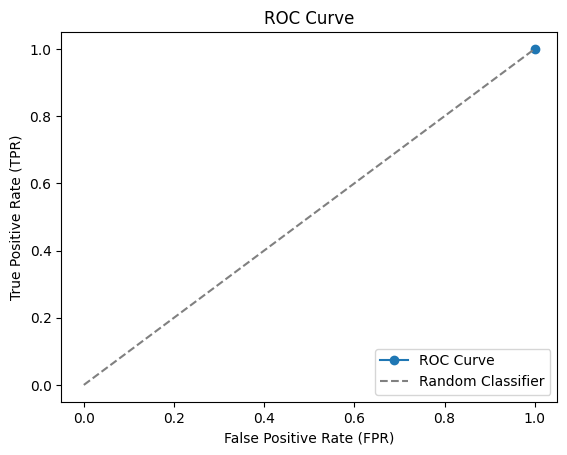

In [113]:
import matplotlib.pyplot as plt

# Sort by predicted scores in descending order.
sorted_indices = np.argsort(-pred)
true = true[sorted_indices]
pred = pred[sorted_indices]

thresh = np.unique(pred)
tpr = []  # True positive rate.
fpr = []  # False positive rate.

# Total positives and negatives.
P = sum(true)
N = len(true) - P

# Iterate through thresholds.
for t in thresh:
  # Classify predictions as positive or negative.
  lab = (pred >= t)

  TP = np.sum((lab == 1) & (true == 1))
  FP = np.sum((lab == 1) & (true == 0))
  FN = np.sum((lab == 0) & (true == 1))
  TN = np.sum((lab == 0) & (true == 0))

  # Calculate TPR and FPR.
  tpr.append(TP/P)
  fpr.append(FP/N)

auc = np.trapz(tpr, fpr)
print(auc)

plt.figure()
plt.plot(fpr, tpr, marker='o', label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Katy Perry

## Data preprocessing/tokenization

In [114]:
# Number of states (ham, spam) and features.
n_states = 2

# Maximum number of words that will be defined its sown token.
n_features = 400

# Load the dataset.
df = pd.read_csv("Youtube02-KatyPerry.csv", header=None, names=["ID", "Author", "Date", "Message", "Label"])

In [115]:
# Map labels ham/spam to binary values.
df['Label'] = df['Label'].map({'0': 0, '1': 1})

# Train/Val/Test split: 80%/10%/10%
train_data = df.sample(n=int((df.shape[0])*0.8), random_state=10)
rem = df.drop(train_data.index)
val_data = rem.sample(n=int((rem.shape[0])*0.5), random_state=10)
test_data = rem.drop(val_data.index)

# Extract text data and labels.
train_text = train_data['Message'].tolist()
train_labels = train_data['Label'].tolist()
val_text = val_data['Message'].tolist()
val_labels = val_data['Label'].tolist()
test_text = test_data['Message'].tolist()
test_labels = test_data['Label'].tolist()

#train_text = train_text[:500]
#train_labels = train_labels[:500]
#val_text = val_text[:100]
#val_labels = val_labels[:100]
#test_text = test_text[:100]
#test_labels = test_labels[:100]

# Initialize a vocabulary and assign each unique word an integer ID.
word_to_id = defaultdict(lambda: len(word_to_id))

# Special tokens for padding and unknown words
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"
word_to_id[PAD_TOKEN] = 0
word_to_id[UNK_TOKEN] = 1

# Function to tokenize and encode each message.
def tokenize_and_encode(msgs, word_to_id):
    encoded_sequences = []
    for msg in msgs:
        tokens = msg.split()
        encoded_msg = [word_to_id[token] if token in word_to_id else word_to_id[UNK_TOKEN]
                           for token in tokens]
        encoded_sequences.append(encoded_msg)
    return encoded_sequences

In [116]:
# Assign each string in the dataset a token
text_data_shuffle = train_data['Message'].tolist()
random.shuffle(text_data_shuffle)
for message in text_data_shuffle:
  tokens = message.split() # Split the strings in each message to process every word separately.
  for token in tokens:
    if len(word_to_id) >= n_features: # Cap the dictionary length to the defined number of features to prevent overfitting.
      break
    _ = word_to_id[token] # If a word isn't already assigned a token, give it a token.
  if len(word_to_id) >= n_features:
    break

In [117]:
print("Vocabulary:", dict(word_to_id))

Vocabulary: {'<PAD>': 0, '<UNK>': 1, 'https://www.facebook.com/pages/Hiphop-Express/704682339621282': 2, 'like': 3, 'this': 4, 'page': 5, 'yo\ufeff': 6, 'please': 7, 'look': 8, 'up': 9, 'DHG': 10, 'SONGS': 11, 'is': 12, 'my': 13, 'playlist': 14, 'with': 15, 'a': 16, 'bunch': 17, 'of': 18, 'amazing': 19, 'songs': 20, '\ufeff': 21, 'Hii': 22, 'youtube\ufeff': 23, 'why': 24, 'the': 25, 'elephant': 26, 'have': 27, 'broken': 28, 'horn\ufeff': 29, 'I': 30, 'love': 31, 'song,': 32, 'it´s': 33, 'for': 34, 'empowering': 35, 'every': 36, 'woman': 37, ':)': 38, '"you´re': 39, 'gonna': 40, 'hear': 41, 'me': 42, 'roar"': 43, ';)\ufeff': 44, 'Follow': 45, 'watch': 46, 'videos': 47, ':)\ufeff': 48, 'LOVE': 49, 'YOU!!!': 50, 'Because': 51, 'u': 52, 'make': 53, 'smile': 54, 'when': 55, 'im': 56, 'sad': 57, 'you': 58, 'cheer': 59, 'your': 60, 'beautiful': 61, '(:': 62, '&lt;3\ufeff': 63, 'Is': 64, 'that': 65, 'tiger': 66, 'called': 67, "'Katty": 68, "Purry'?\ufeff": 69, 'Katy': 70, 'Perry': 71, "can't":

In [118]:
# Apply tokenization and encoding to dataset.
token_text = tokenize_and_encode(train_text, word_to_id)

# Pad sequences to the same length for batch processing.
def pad_sequences(sequences, max_length, pad_value=0):
  padded_sequences = []
  for seq in sequences:
    if len(seq) < max_length:
      padded_seq = seq + [pad_value] * (max_length - len(seq))
    else:
      padded_seq = seq[:max_length]
    padded_sequences.append(padded_seq)
  return padded_sequences

# Set a maximum sequence length.
max_length = 70

#Tokenize the training, validation, and test sequences
train_sequences = pad_sequences(token_text, max_length, pad_value=word_to_id[PAD_TOKEN])
val_sequences = pad_sequences(tokenize_and_encode(val_text, word_to_id), max_length, pad_value=word_to_id[PAD_TOKEN])
test_sequences = pad_sequences(tokenize_and_encode(test_text, word_to_id), max_length, pad_value=word_to_id[PAD_TOKEN])

# Convert sequences and labels to PyTorch tensors.
train_sequences = torch.tensor(train_sequences, dtype=torch.long)
#train_labels = torch.tensor(train_labels, dtype=torch.long)
val_sequences = torch.tensor(val_sequences, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_sequences = torch.tensor(test_sequences, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

##Viterbi algorithm and training

In [119]:
# Define transitions.
A = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states,n_states), dim=0)).float()

# Define emissions.
b = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states,n_features), dim=0)).float()

# Define initial state probabilities; state priors.
pi = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states), dim=0)).float()

In [120]:
def viterbi_decoding(observed_sequences, A, b, pi):

  batch_size, seq_len = observed_sequences.shape
  n_states = A.shape[0]

  # Initialize omega and psi.
  omega = torch.zeros(batch_size, seq_len, n_states).float()
  psi = torch.zeros(batch_size, seq_len, n_states).long()

  # Enable CUDA if available.
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  observed_sequences = observed_sequences.to(device)
  A = A.to(device)
  b = b.to(device)
  pi = pi.to(device)
  omega = omega.to(device)
  psi = psi.to(device)

  # Initialize the omega value.
  omega[:, 0, :] = pi + b[:, observed_sequences[:, 0]].T

  # Recursion.
  for t in range(1, seq_len):
    omega_tminus1 = omega[:, t-1, :].unsqueeze(2)
    log_transition = omega_tminus1 + A.unsqueeze(0)

    # Get max probabilities and their indices.
    max_log_probs, psi[:, t, :] = log_transition.max(dim=1)
    omega[:, t, :] = max_log_probs + b[:, observed_sequences[:, t]].T

  # Backtrace to find the most probable states.
  best_paths = torch.zeros(batch_size, seq_len).long()
  best_paths = best_paths.to(device)
  best_paths[:, -1] = omega[:, -1, :].argmax(dim=1)

  for t in range(seq_len - 2, -1, -1):
    best_paths[:, t] = psi[torch.arange(batch_size), t + 1, best_paths[:, t + 1]]

  # The log probability of the best paths can be accessed from the omega matrix.
  log_prob = omega[torch.arange(batch_size), -1, best_paths[:, -1]]

  return best_paths, log_prob

In [121]:
epochs = 40
batch_size = 32
lr = 0.001

def train_hmm(observed_sequences, A, b, pi, n_epochs, lr, batch_size):
  # Initialize Adam optimizer and gradient clip in case the gradient becomes too large.
  optimizer = optim.Adam([A, b, pi], lr=lr)

  # Calculate number of batches.
  batches = (len(observed_sequences) + batch_size - 1) // b

  # Initialize total loss function and enable gradient calculations.
  for epoch in range(n_epochs):
    total_loss = 0
    optimizer.zero_grad()

    for i in range(0, len(observed_sequences), batch_size):
      batch = observed_sequences[i:i + batch_size]

      # Perform Viterbi decoding and compute negative log-likelihood loss.
      # We only need the log probability for the purposes of training.
      _, log_probs = viterbi_decoding(batch, A, b, pi)
      loss = -log_probs.sum()

      # Backpropagation.
      loss.backward()
      # Add gradient clipping in the case the gradient becomes too large.
      nn.utils.clip_grad_norm_([A, b, pi], max_norm=1.0)
      optimizer.step()

      # Add the calculated loss to the total loss.
      total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {total_loss:.4f}")

In [122]:
train_hmm(train_sequences, A, b, pi, epochs, lr, batch_size)

Epoch 1/40, Loss: 12785.8491
Epoch 2/40, Loss: 12440.2496
Epoch 3/40, Loss: 12095.0161
Epoch 4/40, Loss: 11749.8550
Epoch 5/40, Loss: 11404.7275
Epoch 6/40, Loss: 11059.6282
Epoch 7/40, Loss: 10714.5506
Epoch 8/40, Loss: 10369.4944
Epoch 9/40, Loss: 10024.4535
Epoch 10/40, Loss: 9679.4215
Epoch 11/40, Loss: 9334.3937
Epoch 12/40, Loss: 8989.3735
Epoch 13/40, Loss: 8644.3498
Epoch 14/40, Loss: 8299.3275
Epoch 15/40, Loss: 7954.3190
Epoch 16/40, Loss: 7609.3110
Epoch 17/40, Loss: 7264.3107
Epoch 18/40, Loss: 6919.3134
Epoch 19/40, Loss: 6574.3209
Epoch 20/40, Loss: 6229.3288
Epoch 21/40, Loss: 5884.3263
Epoch 22/40, Loss: 5539.3173
Epoch 23/40, Loss: 5194.3115
Epoch 24/40, Loss: 4849.3097
Epoch 25/40, Loss: 4504.3089
Epoch 26/40, Loss: 4159.3125
Epoch 27/40, Loss: 3814.3100
Epoch 28/40, Loss: 3469.2345
Epoch 29/40, Loss: 3124.1431
Epoch 30/40, Loss: 2779.0527
Epoch 31/40, Loss: 2433.9697
Epoch 32/40, Loss: 2088.8965
Epoch 33/40, Loss: 1743.8294
Epoch 34/40, Loss: 1398.7712
Epoch 35/40, L

## Evaluating the data with inference, ROC curve, and confusion matrix

In [123]:
def predict_labels(observed_sequences, labels, A, b, pi):
#For inference purposes, we only need the best paths from our Viterbi decoding function.
  pred, _ = viterbi_decoding(observed_sequences, A, b, pi)
  states = pred[:,-1]
  print(states)
  correct = (states == labels).sum().item()
  total = labels.numel()
  accuracy = correct / total
  return accuracy, states

In [124]:
val_results, _ = predict_labels(val_sequences, val_labels, A, b, pi)
print(val_labels)
print(val_results)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])
0.45714285714285713


In [125]:
# Define true labels and predicted labels.
true = test_labels.numpy()
_, pred = predict_labels(test_sequences, test_labels, A, b, pi)
pred = pred.numpy()

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [126]:
#C Calculate confusion matrix of the dataset on the test data.
TP = ((pred == 1) & (true == 1)).sum().item()
TN = ((pred == 0) & (true == 0)).sum().item()
FP = ((pred == 1) & (true == 0)).sum().item()
FN = ((pred == 0) & (true == 1)).sum().item()

conf_matrix = torch.tensor([[TN, FP], [FN, TP]])
print(conf_matrix)

tensor([[17,  0],
        [19,  0]])


0.0


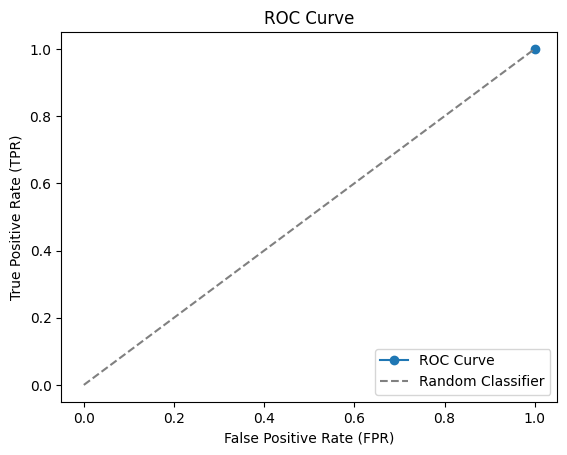

In [127]:
import matplotlib.pyplot as plt

# Sort by predicted scores in descending order.
sorted_indices = np.argsort(-pred)
true = true[sorted_indices]
pred = pred[sorted_indices]

thresh = np.unique(pred)
tpr = []  # True positive rate.
fpr = []  # False positive rate.

# Total positives and negatives.
P = sum(true)
N = len(true) - P

# Iterate through thresholds.
for t in thresh:
  # Classify predictions as positive or negative.
  lab = (pred >= t)

  TP = np.sum((lab == 1) & (true == 1))
  FP = np.sum((lab == 1) & (true == 0))
  FN = np.sum((lab == 0) & (true == 1))
  TN = np.sum((lab == 0) & (true == 0))

  # Calculate TPR and FPR.
  tpr.append(TP/P)
  fpr.append(FP/N)

auc = np.trapz(tpr, fpr)
print(auc)

plt.figure()
plt.plot(fpr, tpr, marker='o', label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# LMFAO

## Data preprocessing/tokenization

In [128]:
# Number of states (ham, spam) and features.
n_states = 2

# Maximum number of words that will be defined its sown token.
n_features = 400

# Load the dataset.
df = pd.read_csv("Youtube03-LMFAO.csv", header=None, names=["ID", "Author", "Date", "Message", "Label"])

In [129]:
# Map labels ham/spam to binary values.
df['Label'] = df['Label'].map({'0': 0, '1': 1})

# Train/Val/Test split: 80%/10%/10%
train_data = df.sample(n=int((df.shape[0])*0.8), random_state=10)
rem = df.drop(train_data.index)
val_data = rem.sample(n=int((rem.shape[0])*0.5), random_state=10)
test_data = rem.drop(val_data.index)

# Extract text data and labels.
train_text = train_data['Message'].tolist()
train_labels = train_data['Label'].tolist()
val_text = val_data['Message'].tolist()
val_labels = val_data['Label'].tolist()
test_text = test_data['Message'].tolist()
test_labels = test_data['Label'].tolist()

#train_text = train_text[:500]
#train_labels = train_labels[:500]
#val_text = val_text[:100]
#val_labels = val_labels[:100]
#test_text = test_text[:100]
#test_labels = test_labels[:100]

# Initialize a vocabulary and assign each unique word an integer ID.
word_to_id = defaultdict(lambda: len(word_to_id))

# Special tokens for padding and unknown words
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"
word_to_id[PAD_TOKEN] = 0
word_to_id[UNK_TOKEN] = 1

# Function to tokenize and encode each message.
def tokenize_and_encode(msgs, word_to_id):
    encoded_sequences = []
    for msg in msgs:
        tokens = msg.split()
        encoded_msg = [word_to_id[token] if token in word_to_id else word_to_id[UNK_TOKEN]
                           for token in tokens]
        encoded_sequences.append(encoded_msg)
    return encoded_sequences

In [130]:
# Assign each string in the dataset a token
text_data_shuffle = train_data['Message'].tolist()
random.shuffle(text_data_shuffle)
for message in text_data_shuffle:
  tokens = message.split() # Split the strings in each message to process every word separately.
  for token in tokens:
    if len(word_to_id) >= n_features: # Cap the dictionary length to the defined number of features to prevent overfitting.
      break
    _ = word_to_id[token] # If a word isn't already assigned a token, give it a token.
  if len(word_to_id) >= n_features:
    break

In [131]:
print("Vocabulary:", dict(word_to_id))

Vocabulary: {'<PAD>': 0, '<UNK>': 1, 'Check': 2, 'out': 3, 'this': 4, 'funny': 5, 'video': 6, '&quot;Cereal': 7, 'Box': 8, 'Knocks': 9, 'Baby&quot;': 10, 'on': 11, 'my': 12, 'channel.\ufeff': 13, 'i': 14, 'want': 15, 'to': 16, 'be': 17, 'that': 18, 'robot': 19, 'guy...\ufeff': 20, 'playlist': 21, 'YouTube:a\ufeff': 22, 'Who': 23, 'df': 24, 'is': 25, 'Lauren': 26, 'Bennett..\ufeff': 27, 'BEST': 28, 'PARTY': 29, 'SONG': 30, 'LITERALLY': 31, 'ROCK': 32, 'IS': 33, 'IN': 34, 'THE': 35, 'HOUSEE': 36, 'TONIGHT!!!!\ufeff': 37, 'PLEASE': 38, 'DON&#39;T': 39, 'LIKE': 40, 'THIS': 41, 'COMMENT': 42, 'IF': 43, 'YOU': 44, 'ARE': 45, 'WATCHING': 46, '2015!!!!!!!!!!!\ufeff': 47, 'our': 48, 'app': 49, 'solve': 50, 'all': 51, 'your': 52, 'party/drunk': 53, 'problems!': 54, '<br': 55, '/><a': 56, 'href="https://play.google.com/store/apps/details?id=vn.ibit.AppLocker&amp;hl=en">https://play.google.com/store/apps/details?id=vn.ibit.AppLocker&amp;hl=en</a>\ufeff': 57, 'subscribe': 58, 'me': 59, 'plzzzzzzz':

In [132]:
# Apply tokenization and encoding to dataset.
token_text = tokenize_and_encode(train_text, word_to_id)

# Pad sequences to the same length for batch processing.
def pad_sequences(sequences, max_length, pad_value=0):
  padded_sequences = []
  for seq in sequences:
    if len(seq) < max_length:
      padded_seq = seq + [pad_value] * (max_length - len(seq))
    else:
      padded_seq = seq[:max_length]
    padded_sequences.append(padded_seq)
  return padded_sequences

# Set a maximum sequence length.
max_length = 70

#Tokenize the training, validation, and test sequences
train_sequences = pad_sequences(token_text, max_length, pad_value=word_to_id[PAD_TOKEN])
val_sequences = pad_sequences(tokenize_and_encode(val_text, word_to_id), max_length, pad_value=word_to_id[PAD_TOKEN])
test_sequences = pad_sequences(tokenize_and_encode(test_text, word_to_id), max_length, pad_value=word_to_id[PAD_TOKEN])

# Convert sequences and labels to PyTorch tensors.
train_sequences = torch.tensor(train_sequences, dtype=torch.long)
#train_labels = torch.tensor(train_labels, dtype=torch.long)
val_sequences = torch.tensor(val_sequences, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_sequences = torch.tensor(test_sequences, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

##Viterbi algorithm and training

In [133]:
# Define transitions.
A = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states,n_states), dim=0)).float()

# Define emissions.
b = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states,n_features), dim=0)).float()

# Define initial state probabilities; state priors.
pi = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states), dim=0)).float()

In [134]:
def viterbi_decoding(observed_sequences, A, b, pi):

  batch_size, seq_len = observed_sequences.shape
  n_states = A.shape[0]

  # Initialize omega and psi.
  omega = torch.zeros(batch_size, seq_len, n_states).float()
  psi = torch.zeros(batch_size, seq_len, n_states).long()

  # Enable CUDA if available.
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  observed_sequences = observed_sequences.to(device)
  A = A.to(device)
  b = b.to(device)
  pi = pi.to(device)
  omega = omega.to(device)
  psi = psi.to(device)

  # Initialize the omega value.
  omega[:, 0, :] = pi + b[:, observed_sequences[:, 0]].T

  # Recursion.
  for t in range(1, seq_len):
    omega_tminus1 = omega[:, t-1, :].unsqueeze(2)
    log_transition = omega_tminus1 + A.unsqueeze(0)

    # Get max probabilities and their indices.
    max_log_probs, psi[:, t, :] = log_transition.max(dim=1)
    omega[:, t, :] = max_log_probs + b[:, observed_sequences[:, t]].T

  # Backtrace to find the most probable states.
  best_paths = torch.zeros(batch_size, seq_len).long()
  best_paths = best_paths.to(device)
  best_paths[:, -1] = omega[:, -1, :].argmax(dim=1)

  for t in range(seq_len - 2, -1, -1):
    best_paths[:, t] = psi[torch.arange(batch_size), t + 1, best_paths[:, t + 1]]

  # The log probability of the best paths can be accessed from the omega matrix.
  log_prob = omega[torch.arange(batch_size), -1, best_paths[:, -1]]

  return best_paths, log_prob

In [135]:
epochs = 40
batch_size = 32
lr = 0.001

def train_hmm(observed_sequences, A, b, pi, n_epochs, lr, batch_size):
  # Initialize Adam optimizer and gradient clip in case the gradient becomes too large.
  optimizer = optim.Adam([A, b, pi], lr=lr)

  # Calculate number of batches.
  batches = (len(observed_sequences) + batch_size - 1) // b

  # Initialize total loss function and enable gradient calculations.
  for epoch in range(n_epochs):
    total_loss = 0
    optimizer.zero_grad()

    for i in range(0, len(observed_sequences), batch_size):
      batch = observed_sequences[i:i + batch_size]

      # Perform Viterbi decoding and compute negative log-likelihood loss.
      # We only need the log probability for the purposes of training.
      _, log_probs = viterbi_decoding(batch, A, b, pi)
      loss = -log_probs.sum()

      # Backpropagation.
      loss.backward()
      # Add gradient clipping in the case the gradient becomes too large.
      nn.utils.clip_grad_norm_([A, b, pi], max_norm=1.0)
      optimizer.step()

      # Add the calculated loss to the total loss.
      total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {total_loss:.4f}")

In [136]:
train_hmm(train_sequences, A, b, pi, epochs, lr, batch_size)

Epoch 1/40, Loss: 18079.0406
Epoch 2/40, Loss: 17545.8502
Epoch 3/40, Loss: 17013.1584
Epoch 4/40, Loss: 16480.6497
Epoch 5/40, Loss: 15948.2659
Epoch 6/40, Loss: 15415.9828
Epoch 7/40, Loss: 14883.7649
Epoch 8/40, Loss: 14351.5964
Epoch 9/40, Loss: 13819.4727
Epoch 10/40, Loss: 13287.3763
Epoch 11/40, Loss: 12755.3002
Epoch 12/40, Loss: 12223.2451
Epoch 13/40, Loss: 11691.2079
Epoch 14/40, Loss: 11159.1814
Epoch 15/40, Loss: 10627.1677
Epoch 16/40, Loss: 10095.1650
Epoch 17/40, Loss: 9563.1717
Epoch 18/40, Loss: 9031.1887
Epoch 19/40, Loss: 8499.2075
Epoch 20/40, Loss: 7967.2349
Epoch 21/40, Loss: 7435.2678
Epoch 22/40, Loss: 6903.3108
Epoch 23/40, Loss: 6371.3484
Epoch 24/40, Loss: 5839.3932
Epoch 25/40, Loss: 5307.4451
Epoch 26/40, Loss: 4775.4992
Epoch 27/40, Loss: 4243.5575
Epoch 28/40, Loss: 3711.6144
Epoch 29/40, Loss: 3179.6776
Epoch 30/40, Loss: 2647.7425
Epoch 31/40, Loss: 2115.8095
Epoch 32/40, Loss: 1583.8796
Epoch 33/40, Loss: 1051.9502
Epoch 34/40, Loss: 520.0199
Epoch 35

## Evaluating the data with inference, ROC curve, and confusion matrix

In [137]:
def predict_labels(observed_sequences, labels, A, b, pi):
#For inference purposes, we only need the best paths from our Viterbi decoding function.
  pred, _ = viterbi_decoding(observed_sequences, A, b, pi)
  states = pred[:,-1]
  print(states)
  correct = (states == labels).sum().item()
  total = labels.numel()
  accuracy = correct / total
  return accuracy, states

In [138]:
val_results, _ = predict_labels(val_sequences, val_labels, A, b, pi)
print(val_labels)
print(val_results)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1])
0.5681818181818182


In [139]:
# Define true labels and predicted labels.
true = test_labels.numpy()
_, pred = predict_labels(test_sequences, test_labels, A, b, pi)
pred = pred.numpy()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [140]:
#C Calculate confusion matrix of the dataset on the test data.
TP = ((pred == 1) & (true == 1)).sum().item()
TN = ((pred == 0) & (true == 0)).sum().item()
FP = ((pred == 1) & (true == 0)).sum().item()
FN = ((pred == 0) & (true == 1)).sum().item()

conf_matrix = torch.tensor([[TN, FP], [FN, TP]])
print(conf_matrix)

tensor([[ 0, 22],
        [ 0, 22]])


0.0


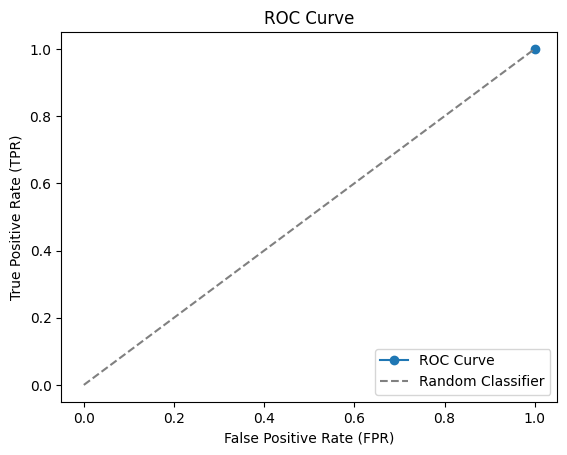

In [141]:
import matplotlib.pyplot as plt

# Sort by predicted scores in descending order.
sorted_indices = np.argsort(-pred)
true = true[sorted_indices]
pred = pred[sorted_indices]

thresh = np.unique(pred)
tpr = []  # True positive rate.
fpr = []  # False positive rate.

# Total positives and negatives.
P = sum(true)
N = len(true) - P

# Iterate through thresholds.
for t in thresh:
  # Classify predictions as positive or negative.
  lab = (pred >= t)

  TP = np.sum((lab == 1) & (true == 1))
  FP = np.sum((lab == 1) & (true == 0))
  FN = np.sum((lab == 0) & (true == 1))
  TN = np.sum((lab == 0) & (true == 0))

  # Calculate TPR and FPR.
  tpr.append(TP/P)
  fpr.append(FP/N)

auc = np.trapz(tpr, fpr)
print(auc)

plt.figure()
plt.plot(fpr, tpr, marker='o', label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Eminem

## Data preprocessing/tokenization

In [142]:
# Number of states (ham, spam) and features.
n_states = 2

# Maximum number of words that will be defined its sown token.
n_features = 400

# Load the dataset.
df = pd.read_csv("Youtube04-Eminem.csv", header=None, names=["ID", "Author", "Date", "Message", "Label"])

In [143]:
# Map labels ham/spam to binary values.
df['Label'] = df['Label'].map({'0': 0, '1': 1})

# Train/Val/Test split: 80%/10%/10%
train_data = df.sample(n=int((df.shape[0])*0.8), random_state=10)
rem = df.drop(train_data.index)
val_data = rem.sample(n=int((rem.shape[0])*0.5), random_state=10)
test_data = rem.drop(val_data.index)

# Extract text data and labels.
train_text = train_data['Message'].tolist()
train_labels = train_data['Label'].tolist()
val_text = val_data['Message'].tolist()
val_labels = val_data['Label'].tolist()
test_text = test_data['Message'].tolist()
test_labels = test_data['Label'].tolist()

#train_text = train_text[:500]
#train_labels = train_labels[:500]
#val_text = val_text[:100]
#val_labels = val_labels[:100]
#test_text = test_text[:100]
#test_labels = test_labels[:100]

# Initialize a vocabulary and assign each unique word an integer ID.
word_to_id = defaultdict(lambda: len(word_to_id))

# Special tokens for padding and unknown words
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"
word_to_id[PAD_TOKEN] = 0
word_to_id[UNK_TOKEN] = 1

# Function to tokenize and encode each message.
def tokenize_and_encode(msgs, word_to_id):
    encoded_sequences = []
    for msg in msgs:
        tokens = msg.split()
        encoded_msg = [word_to_id[token] if token in word_to_id else word_to_id[UNK_TOKEN]
                           for token in tokens]
        encoded_sequences.append(encoded_msg)
    return encoded_sequences

In [144]:
# Assign each string in the dataset a token
text_data_shuffle = train_data['Message'].tolist()
random.shuffle(text_data_shuffle)
for message in text_data_shuffle:
  tokens = message.split() # Split the strings in each message to process every word separately.
  for token in tokens:
    if len(word_to_id) >= n_features: # Cap the dictionary length to the defined number of features to prevent overfitting.
      break
    _ = word_to_id[token] # If a word isn't already assigned a token, give it a token.
  if len(word_to_id) >= n_features:
    break

In [145]:
print("Vocabulary:", dict(word_to_id))

Vocabulary: {'<PAD>': 0, '<UNK>': 1, 'Please': 2, 'check': 3, 'out': 4, 'my': 5, 'New': 6, 'Song': 7, '(Music': 8, 'Video)': 9, 'AD': 10, '-': 11, 'Don&#39;t': 12, 'Play': 13, 'I': 14, 'love': 15, 'music\ufeff': 16, 'Getting': 17, 'too': 18, '1billion': 19, 'views,': 20, 'holy': 21, 'moly.!!!\ufeff': 22, 'if': 23, 'u': 24, 'rihanna': 25, 'subscribe': 26, 'me': 27, 'this-the': 28, 'talents': 29, 'of': 30, 'eminem': 31, 'and': 32, 'Skylar,works': 33, 'well': 34, 'together\ufeff': 35, 'This': 36, 'song/video': 37, 'is': 38, 'such': 39, 'a': 40, 'trigger': 41, 'but': 42, 'it&#39;s': 43, 'just': 44, 'so': 45, 'good...\ufeff': 46, 'Eminem': 47, 'et': 48, 'Rihana': 49, 'trop': 50, 'belle': 51, 'chanson\ufeff': 52, 'know': 53, 'that': 54, 'maybe': 55, 'no': 56, 'one': 57, 'will': 58, 'read': 59, 'this': 60, 'PLEASE': 61, 'TYPE': 62, 'IN': 63, '&quot;deazy99&quot;': 64, 'I&#39;m': 65, 'rapper': 66, 'with': 67, 'dream.': 68, 'you': 69, 'must': 70, 'see': 71, 'like': 72, 'millions': 73, 'those': 

In [146]:
# Apply tokenization and encoding to dataset.
token_text = tokenize_and_encode(train_text, word_to_id)

# Pad sequences to the same length for batch processing.
def pad_sequences(sequences, max_length, pad_value=0):
  padded_sequences = []
  for seq in sequences:
    if len(seq) < max_length:
      padded_seq = seq + [pad_value] * (max_length - len(seq))
    else:
      padded_seq = seq[:max_length]
    padded_sequences.append(padded_seq)
  return padded_sequences

# Set a maximum sequence length.
max_length = 70

#Tokenize the training, validation, and test sequences
train_sequences = pad_sequences(token_text, max_length, pad_value=word_to_id[PAD_TOKEN])
val_sequences = pad_sequences(tokenize_and_encode(val_text, word_to_id), max_length, pad_value=word_to_id[PAD_TOKEN])
test_sequences = pad_sequences(tokenize_and_encode(test_text, word_to_id), max_length, pad_value=word_to_id[PAD_TOKEN])

# Convert sequences and labels to PyTorch tensors.
train_sequences = torch.tensor(train_sequences, dtype=torch.long)
#train_labels = torch.tensor(train_labels, dtype=torch.long)
val_sequences = torch.tensor(val_sequences, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_sequences = torch.tensor(test_sequences, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

##Viterbi algorithm and training

In [147]:
# Define transitions.
A = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states,n_states), dim=0)).float()

# Define emissions.
b = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states,n_features), dim=0)).float()

# Define initial state probabilities; state priors.
pi = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states), dim=0)).float()

In [148]:
def viterbi_decoding(observed_sequences, A, b, pi):

  batch_size, seq_len = observed_sequences.shape
  n_states = A.shape[0]

  # Initialize omega and psi.
  omega = torch.zeros(batch_size, seq_len, n_states).float()
  psi = torch.zeros(batch_size, seq_len, n_states).long()

  # Enable CUDA if available.
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  observed_sequences = observed_sequences.to(device)
  A = A.to(device)
  b = b.to(device)
  pi = pi.to(device)
  omega = omega.to(device)
  psi = psi.to(device)

  # Initialize the omega value.
  omega[:, 0, :] = pi + b[:, observed_sequences[:, 0]].T

  # Recursion.
  for t in range(1, seq_len):
    omega_tminus1 = omega[:, t-1, :].unsqueeze(2)
    log_transition = omega_tminus1 + A.unsqueeze(0)

    # Get max probabilities and their indices.
    max_log_probs, psi[:, t, :] = log_transition.max(dim=1)
    omega[:, t, :] = max_log_probs + b[:, observed_sequences[:, t]].T

  # Backtrace to find the most probable states.
  best_paths = torch.zeros(batch_size, seq_len).long()
  best_paths = best_paths.to(device)
  best_paths[:, -1] = omega[:, -1, :].argmax(dim=1)

  for t in range(seq_len - 2, -1, -1):
    best_paths[:, t] = psi[torch.arange(batch_size), t + 1, best_paths[:, t + 1]]

  # The log probability of the best paths can be accessed from the omega matrix.
  log_prob = omega[torch.arange(batch_size), -1, best_paths[:, -1]]

  return best_paths, log_prob

In [149]:
epochs = 40
batch_size = 32
lr = 0.001

def train_hmm(observed_sequences, A, b, pi, n_epochs, lr, batch_size):
  # Initialize Adam optimizer and gradient clip in case the gradient becomes too large.
  optimizer = optim.Adam([A, b, pi], lr=lr)

  # Calculate number of batches.
  batches = (len(observed_sequences) + batch_size - 1) // b

  # Initialize total loss function and enable gradient calculations.
  for epoch in range(n_epochs):
    total_loss = 0
    optimizer.zero_grad()

    for i in range(0, len(observed_sequences), batch_size):
      batch = observed_sequences[i:i + batch_size]

      # Perform Viterbi decoding and compute negative log-likelihood loss.
      # We only need the log probability for the purposes of training.
      _, log_probs = viterbi_decoding(batch, A, b, pi)
      loss = -log_probs.sum()

      # Backpropagation.
      loss.backward()
      # Add gradient clipping in the case the gradient becomes too large.
      nn.utils.clip_grad_norm_([A, b, pi], max_norm=1.0)
      optimizer.step()

      # Add the calculated loss to the total loss.
      total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {total_loss:.4f}")

In [150]:
train_hmm(train_sequences, A, b, pi, epochs, lr, batch_size)

Epoch 1/40, Loss: 21475.3033
Epoch 2/40, Loss: 20885.4706
Epoch 3/40, Loss: 20295.8539
Epoch 4/40, Loss: 19706.3005
Epoch 5/40, Loss: 19116.8066
Epoch 6/40, Loss: 18527.3499
Epoch 7/40, Loss: 17937.9034
Epoch 8/40, Loss: 17348.4808
Epoch 9/40, Loss: 16759.0699
Epoch 10/40, Loss: 16169.6628
Epoch 11/40, Loss: 15580.2708
Epoch 12/40, Loss: 14990.8780
Epoch 13/40, Loss: 14401.4947
Epoch 14/40, Loss: 13812.1124
Epoch 15/40, Loss: 13222.7380
Epoch 16/40, Loss: 12633.3584
Epoch 17/40, Loss: 12043.9821
Epoch 18/40, Loss: 11454.5906
Epoch 19/40, Loss: 10865.1617
Epoch 20/40, Loss: 10275.7179
Epoch 21/40, Loss: 9686.2827
Epoch 22/40, Loss: 9096.8468
Epoch 23/40, Loss: 8507.4180
Epoch 24/40, Loss: 7917.9944
Epoch 25/40, Loss: 7328.5760
Epoch 26/40, Loss: 6739.1620
Epoch 27/40, Loss: 6149.7513
Epoch 28/40, Loss: 5560.3446
Epoch 29/40, Loss: 4970.9421
Epoch 30/40, Loss: 4381.5418
Epoch 31/40, Loss: 3792.1462
Epoch 32/40, Loss: 3202.7512
Epoch 33/40, Loss: 2613.3590
Epoch 34/40, Loss: 2023.9700
Epo

## Evaluating the data with inference, ROC curve, and confusion matrix

In [151]:
def predict_labels(observed_sequences, labels, A, b, pi):
#For inference purposes, we only need the best paths from our Viterbi decoding function.
  pred, _ = viterbi_decoding(observed_sequences, A, b, pi)
  states = pred[:,-1]
  print(states)
  correct = (states == labels).sum().item()
  total = labels.numel()
  accuracy = correct / total
  return accuracy, states

In [152]:
val_results, _ = predict_labels(val_sequences, val_labels, A, b, pi)
print(val_labels)
print(val_results)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1])
0.5555555555555556


In [153]:
# Define true labels and predicted labels.
true = test_labels.numpy()
_, pred = predict_labels(test_sequences, test_labels, A, b, pi)
pred = pred.numpy()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])


In [154]:
#C Calculate confusion matrix of the dataset on the test data.
TP = ((pred == 1) & (true == 1)).sum().item()
TN = ((pred == 0) & (true == 0)).sum().item()
FP = ((pred == 1) & (true == 0)).sum().item()
FN = ((pred == 0) & (true == 1)).sum().item()

conf_matrix = torch.tensor([[TN, FP], [FN, TP]])
print(conf_matrix)

tensor([[ 0, 19],
        [ 2, 24]])


0.0


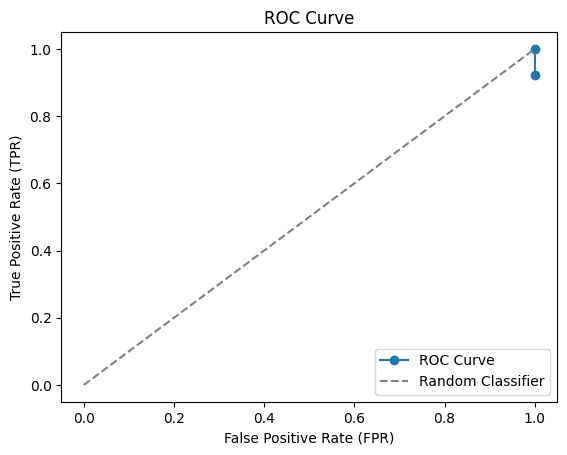

In [155]:
import matplotlib.pyplot as plt

# Sort by predicted scores in descending order.
sorted_indices = np.argsort(-pred)
true = true[sorted_indices]
pred = pred[sorted_indices]

thresh = np.unique(pred)
tpr = []  # True positive rate.
fpr = []  # False positive rate.

# Total positives and negatives.
P = sum(true)
N = len(true) - P

# Iterate through thresholds.
for t in thresh:
  # Classify predictions as positive or negative.
  lab = (pred >= t)

  TP = np.sum((lab == 1) & (true == 1))
  FP = np.sum((lab == 1) & (true == 0))
  FN = np.sum((lab == 0) & (true == 1))
  TN = np.sum((lab == 0) & (true == 0))

  # Calculate TPR and FPR.
  tpr.append(TP/P)
  fpr.append(FP/N)

auc = np.trapz(tpr, fpr)
print(auc)

plt.figure()
plt.plot(fpr, tpr, marker='o', label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Shakira

## Data preprocessing/tokenization

In [156]:
# Number of states (ham, spam) and features.
n_states = 2

# Maximum number of words that will be defined its sown token.
n_features = 400

# Load the dataset.
df = pd.read_csv("Youtube05-Shakira.csv", header=None, names=["ID", "Author", "Date", "Message", "Label"])

In [157]:
# Map labels ham/spam to binary values.
df['Label'] = df['Label'].map({'0': 0, '1': 1})

# Train/Val/Test split: 80%/10%/10%
train_data = df.sample(n=int((df.shape[0])*0.8), random_state=10)
rem = df.drop(train_data.index)
val_data = rem.sample(n=int((rem.shape[0])*0.5), random_state=10)
test_data = rem.drop(val_data.index)

# Extract text data and labels.
train_text = train_data['Message'].tolist()
train_labels = train_data['Label'].tolist()
val_text = val_data['Message'].tolist()
val_labels = val_data['Label'].tolist()
test_text = test_data['Message'].tolist()
test_labels = test_data['Label'].tolist()

#train_text = train_text[:500]
#train_labels = train_labels[:500]
#val_text = val_text[:100]
#val_labels = val_labels[:100]
#test_text = test_text[:100]
#test_labels = test_labels[:100]

# Initialize a vocabulary and assign each unique word an integer ID.
word_to_id = defaultdict(lambda: len(word_to_id))

# Special tokens for padding and unknown words
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"
word_to_id[PAD_TOKEN] = 0
word_to_id[UNK_TOKEN] = 1

# Function to tokenize and encode each message.
def tokenize_and_encode(msgs, word_to_id):
    encoded_sequences = []
    for msg in msgs:
        tokens = msg.split()
        encoded_msg = [word_to_id[token] if token in word_to_id else word_to_id[UNK_TOKEN]
                           for token in tokens]
        encoded_sequences.append(encoded_msg)
    return encoded_sequences

In [158]:
# Assign each string in the dataset a token
text_data_shuffle = train_data['Message'].tolist()
random.shuffle(text_data_shuffle)
for message in text_data_shuffle:
  tokens = message.split() # Split the strings in each message to process every word separately.
  for token in tokens:
    if len(word_to_id) >= n_features: # Cap the dictionary length to the defined number of features to prevent overfitting.
      break
    _ = word_to_id[token] # If a word isn't already assigned a token, give it a token.
  if len(word_to_id) >= n_features:
    break

In [159]:
print("Vocabulary:", dict(word_to_id))

Vocabulary: {'<PAD>': 0, '<UNK>': 1, 'Check': 2, 'out': 3, 'this': 4, 'playlist': 5, 'on': 6, 'YouTube:\ufeff': 7, 'You': 8, 'guys': 9, 'should': 10, 'check': 11, 'EXTRAORDINARY': 12, 'website': 13, 'called': 14, 'ZONEPA.COM': 15, '.': 16, 'can': 17, 'make': 18, 'money': 19, 'online': 20, 'and': 21, 'start': 22, 'working': 23, 'from': 24, 'home': 25, 'today': 26, 'as': 27, 'I': 28, 'am!': 29, 'am': 30, 'making': 31, 'over': 32, '$3,000+': 33, 'per': 34, 'month': 35, 'at': 36, '!': 37, 'Visit': 38, 'Zonepa.com': 39, 'it': 40, 'out!': 41, 'The': 42, 'meat': 43, 'discusss': 44, 'the': 45, 'successful': 46, 'memory.': 47, 'How': 48, 'does': 49, 'peaceful': 50, 'unit': 51, 'arbitrate': 52, 'guide?': 53, 'addition': 54, 'designs': 55, 'worried': 56, 'loss.': 57, 'My': 58, 'friend': 59, 'Sam': 60, 'loves': 61, 'song😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊\ufeff': 62, 'Hey': 63, 'Music': 64, 'Fans': 65, 'really': 66, 'appreciate': 67, 'any': 68, 'of': 69, 'you': 70, 'who': 71, 'will': 72

In [160]:
# Apply tokenization and encoding to dataset.
token_text = tokenize_and_encode(train_text, word_to_id)

# Pad sequences to the same length for batch processing.
def pad_sequences(sequences, max_length, pad_value=0):
  padded_sequences = []
  for seq in sequences:
    if len(seq) < max_length:
      padded_seq = seq + [pad_value] * (max_length - len(seq))
    else:
      padded_seq = seq[:max_length]
    padded_sequences.append(padded_seq)
  return padded_sequences

# Set a maximum sequence length.
max_length = 70

#Tokenize the training, validation, and test sequences
train_sequences = pad_sequences(token_text, max_length, pad_value=word_to_id[PAD_TOKEN])
val_sequences = pad_sequences(tokenize_and_encode(val_text, word_to_id), max_length, pad_value=word_to_id[PAD_TOKEN])
test_sequences = pad_sequences(tokenize_and_encode(test_text, word_to_id), max_length, pad_value=word_to_id[PAD_TOKEN])

# Convert sequences and labels to PyTorch tensors.
train_sequences = torch.tensor(train_sequences, dtype=torch.long)
#train_labels = torch.tensor(train_labels, dtype=torch.long)
val_sequences = torch.tensor(val_sequences, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_sequences = torch.tensor(test_sequences, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

##Viterbi algorithm and training

In [161]:
# Define transitions.
A = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states,n_states), dim=0)).float()

# Define emissions.
b = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states,n_features), dim=0)).float()

# Define initial state probabilities; state priors.
pi = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states), dim=0)).float()

In [162]:
def viterbi_decoding(observed_sequences, A, b, pi):

  batch_size, seq_len = observed_sequences.shape
  n_states = A.shape[0]

  # Initialize omega and psi.
  omega = torch.zeros(batch_size, seq_len, n_states).float()
  psi = torch.zeros(batch_size, seq_len, n_states).long()

  # Enable CUDA if available.
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  observed_sequences = observed_sequences.to(device)
  A = A.to(device)
  b = b.to(device)
  pi = pi.to(device)
  omega = omega.to(device)
  psi = psi.to(device)

  # Initialize the omega value.
  omega[:, 0, :] = pi + b[:, observed_sequences[:, 0]].T

  # Recursion.
  for t in range(1, seq_len):
    omega_tminus1 = omega[:, t-1, :].unsqueeze(2)
    log_transition = omega_tminus1 + A.unsqueeze(0)

    # Get max probabilities and their indices.
    max_log_probs, psi[:, t, :] = log_transition.max(dim=1)
    omega[:, t, :] = max_log_probs + b[:, observed_sequences[:, t]].T

  # Backtrace to find the most probable states.
  best_paths = torch.zeros(batch_size, seq_len).long()
  best_paths = best_paths.to(device)
  best_paths[:, -1] = omega[:, -1, :].argmax(dim=1)

  for t in range(seq_len - 2, -1, -1):
    best_paths[:, t] = psi[torch.arange(batch_size), t + 1, best_paths[:, t + 1]]

  # The log probability of the best paths can be accessed from the omega matrix.
  log_prob = omega[torch.arange(batch_size), -1, best_paths[:, -1]]

  return best_paths, log_prob

In [163]:
epochs = 40
batch_size = 32
lr = 0.001

def train_hmm(observed_sequences, A, b, pi, n_epochs, lr, batch_size):
  # Initialize Adam optimizer and gradient clip in case the gradient becomes too large.
  optimizer = optim.Adam([A, b, pi], lr=lr)

  # Calculate number of batches.
  batches = (len(observed_sequences) + batch_size - 1) // b

  # Initialize total loss function and enable gradient calculations.
  for epoch in range(n_epochs):
    total_loss = 0
    optimizer.zero_grad()

    for i in range(0, len(observed_sequences), batch_size):
      batch = observed_sequences[i:i + batch_size]

      # Perform Viterbi decoding and compute negative log-likelihood loss.
      # We only need the log probability for the purposes of training.
      _, log_probs = viterbi_decoding(batch, A, b, pi)
      loss = -log_probs.sum()

      # Backpropagation.
      loss.backward()
      # Add gradient clipping in the case the gradient becomes too large.
      nn.utils.clip_grad_norm_([A, b, pi], max_norm=1.0)
      optimizer.step()

      # Add the calculated loss to the total loss.
      total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {total_loss:.4f}")

In [164]:
train_hmm(train_sequences, A, b, pi, epochs, lr, batch_size)

Epoch 1/40, Loss: 17296.6649
Epoch 2/40, Loss: 16893.6767
Epoch 3/40, Loss: 16491.7437
Epoch 4/40, Loss: 16090.0388
Epoch 5/40, Loss: 15688.4847
Epoch 6/40, Loss: 15287.0284
Epoch 7/40, Loss: 14885.6443
Epoch 8/40, Loss: 14484.3319
Epoch 9/40, Loss: 14083.0579
Epoch 10/40, Loss: 13681.8140
Epoch 11/40, Loss: 13280.6172
Epoch 12/40, Loss: 12879.4243
Epoch 13/40, Loss: 12478.2608
Epoch 14/40, Loss: 12077.1084
Epoch 15/40, Loss: 11675.9743
Epoch 16/40, Loss: 11274.8473
Epoch 17/40, Loss: 10873.7291
Epoch 18/40, Loss: 10472.6198
Epoch 19/40, Loss: 10071.5291
Epoch 20/40, Loss: 9670.4332
Epoch 21/40, Loss: 9269.3522
Epoch 22/40, Loss: 8868.2711
Epoch 23/40, Loss: 8467.1986
Epoch 24/40, Loss: 8066.1286
Epoch 25/40, Loss: 7665.0589
Epoch 26/40, Loss: 7263.9650
Epoch 27/40, Loss: 6862.6501
Epoch 28/40, Loss: 6461.2432
Epoch 29/40, Loss: 6059.7984
Epoch 30/40, Loss: 5658.3586
Epoch 31/40, Loss: 5256.9052
Epoch 32/40, Loss: 4855.4382
Epoch 33/40, Loss: 4453.9778
Epoch 34/40, Loss: 4052.5305
Epoc

## Evaluating the data with inference, ROC curve, and confusion matrix

In [165]:
def predict_labels(observed_sequences, labels, A, b, pi):
#For inference purposes, we only need the best paths from our Viterbi decoding function.
  pred, _ = viterbi_decoding(observed_sequences, A, b, pi)
  states = pred[:,-1]
  print(states)
  correct = (states == labels).sum().item()
  total = labels.numel()
  accuracy = correct / total
  return accuracy, states

In [166]:
val_results, _ = predict_labels(val_sequences, val_labels, A, b, pi)
print(val_labels)
print(val_results)

tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])
0.40540540540540543


In [167]:
# Define true labels and predicted labels.
true = test_labels.numpy()
_, pred = predict_labels(test_sequences, test_labels, A, b, pi)
pred = pred.numpy()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [168]:
#C Calculate confusion matrix of the dataset on the test data.
TP = ((pred == 1) & (true == 1)).sum().item()
TN = ((pred == 0) & (true == 0)).sum().item()
FP = ((pred == 1) & (true == 0)).sum().item()
FN = ((pred == 0) & (true == 1)).sum().item()

conf_matrix = torch.tensor([[TN, FP], [FN, TP]])
print(conf_matrix)

tensor([[ 0, 27],
        [ 0, 11]])


0.0


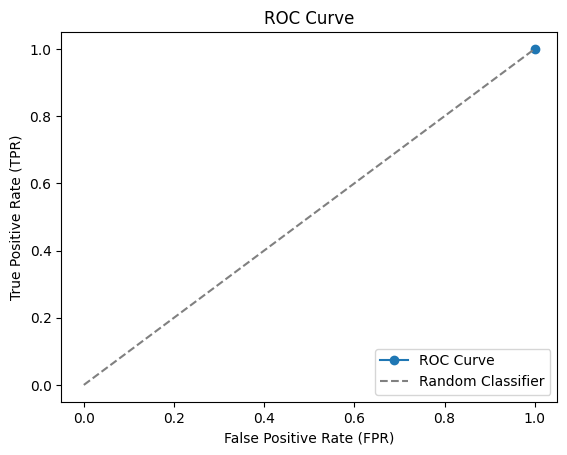

In [169]:
import matplotlib.pyplot as plt

# Sort by predicted scores in descending order.
sorted_indices = np.argsort(-pred)
true = true[sorted_indices]
pred = pred[sorted_indices]

thresh = np.unique(pred)
tpr = []  # True positive rate.
fpr = []  # False positive rate.

# Total positives and negatives.
P = sum(true)
N = len(true) - P

# Iterate through thresholds.
for t in thresh:
  # Classify predictions as positive or negative.
  lab = (pred >= t)

  TP = np.sum((lab == 1) & (true == 1))
  FP = np.sum((lab == 1) & (true == 0))
  FN = np.sum((lab == 0) & (true == 1))
  TN = np.sum((lab == 0) & (true == 0))

  # Calculate TPR and FPR.
  tpr.append(TP/P)
  fpr.append(FP/N)

auc = np.trapz(tpr, fpr)
print(auc)

plt.figure()
plt.plot(fpr, tpr, marker='o', label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()